In [23]:
import tensorflow as tf

class FruitNet:
    def __init__(self, model_config_path):
        self.model = tf.keras.models.load_model(model_config_path)

    def predict(self, img_file):
        labels = ['fresh', 'rotten']

        img_tensor = tf.image.decode_image(img_file)
        img_resized = tf.image.resize(img_tensor, [224, 224])
        img_final = tf.expand_dims(img_resized, 0)

        y_probs = self.model.predict(img_final[:,:,:,:3])
        y_label = y_probs.argmax(axis=-1)

        label = labels[y_label[0]]
        percentage = format(y_probs.max() * 100, '.2f')

        return label, percentage

In [28]:
train_path = './Dataset/train'
valid_path = './Dataset/val'
test_path = './Dataset/test'
img_size =  (224,224,3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 30

In [29]:
datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             channel_shift_range = 10,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

In [33]:
train_dataset = datagen.flow_from_directory(directory = train_path, 
                                                  color_mode = "rgb",
                                                  target_size = (224,224),
                                                  interpolation = 'bicubic',
                                                  class_mode = "categorical", 
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE)

validation_dataset  = datagen.flow_from_directory(directory = valid_path,
                                            color_mode = "rgb",
                                            target_size = (224,224),
                                            interpolation = 'bicubic',
                                            class_mode = "categorical",
                                            shuffle = False,
                                            batch_size = BATCH_SIZE)
test_dataset  = datagen.flow_from_directory(directory = test_path,
                                           color_mode = "rgb",
                                           target_size = (224,224),
                                           interpolation = 'bicubic',
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = BATCH_SIZE)

Found 306 images belonging to 2 classes.
Found 131 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [34]:
LABELS = ['fresh', 'rotten']

In [38]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [39]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [40]:
base_model.trainable = False

In [41]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 1280)


In [42]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [46]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 2)


In [47]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [48]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [50]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 17s 588ms/step - loss: 0.9571 - accuracy: 0.5038


In [51]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.50


In [52]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/30
39/39 [==============================] - 30s 610ms/step - loss: 0.8988 - accuracy: 0.5229 - val_loss: 0.5237 - val_accuracy: 0.7710
Epoch 2/30
39/39 [==============================] - 27s 692ms/step - loss: 0.5342 - accuracy: 0.7516 - val_loss: 0.3924 - val_accuracy: 0.8321
Epoch 3/30
39/39 [==============================] - 27s 697ms/step - loss: 0.4473 - accuracy: 0.7974 - val_loss: 0.4069 - val_accuracy: 0.8168
Epoch 4/30
39/39 [==============================] - 27s 699ms/step - loss: 0.3775 - accuracy: 0.8268 - val_loss: 0.3268 - val_accuracy: 0.8702
Epoch 5/30
39/39 [==============================] - 28s 715ms/step - loss: 0.3398 - accuracy: 0.8758 - val_loss: 0.3392 - val_accuracy: 0.8550
Epoch 6/30
39/39 [==============================] - 27s 701ms/step - loss: 0.3028 - accuracy: 0.8595 - val_loss: 0.3117 - val_accuracy: 0.8626
Epoch 7/30
39/39 [==============================] - 27s 700ms/step - loss: 0.2385 - accuracy: 0.9020 - val_loss: 0.3358 - val_accuracy: 0.8702

In [53]:
score = model.evaluate(test_dataset)
print("Accuracy: ",score[1])

11/11 [==============================] - 36s 4s/step - loss: 0.2833 - accuracy: 0.8851
Accuracy:  0.8850574493408203


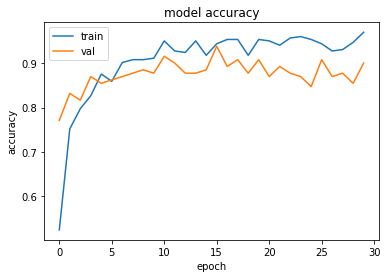

In [54]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

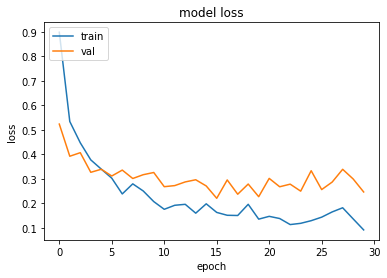

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
from sklearn.metrics import classification_report
test_labels = test_dataset.classes 
predictions = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_dataset.class_indices))

11/11 [==============================] - 7s 598ms/step
              precision    recall  f1-score   support

       Curuk       0.86      0.86      0.86        29
        Taze       0.93      0.93      0.93        58

    accuracy                           0.91        87
   macro avg       0.90      0.90      0.90        87
weighted avg       0.91      0.91      0.91        87



In [66]:
from PIL import Image

img_path='plum_images.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)

1/1 [==============================] - 4s 4s/step


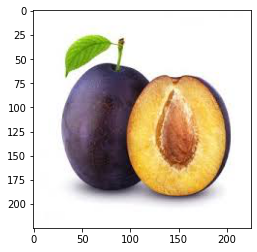

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("plum_images.jpg")
plt.imshow(img)
plt.show()

In [67]:
prediction

array([[0.976112  , 0.02388795]], dtype=float32)

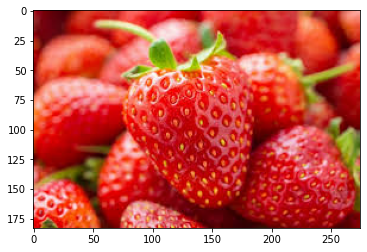

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("strawberry_images.jpg")
plt.imshow(img)
plt.show()

In [69]:
img_path='strawberry_images.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)

1/1 [==============================] - 0s 275ms/step


In [70]:
prediction

array([[0.99179685, 0.00820317]], dtype=float32)

In [73]:
img_path='curuk (2).jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)

1/1 [==============================] - 0s 105ms/step


In [74]:
prediction

array([[0.9783093 , 0.02169072]], dtype=float32)